In [ ]:
import os
import numpy as np
import cv2
from glob import glob
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Conv2D, Activation, BatchNormalization
from tensorflow.keras.layers import UpSampling2D, Input, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau,ModelCheckpoint,CSVLogger
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
print("Tensorflow version: ", tf.__version__)
print(tf.test.gpu_device_name())

Tensorflow version:  2.4.1
/device:GPU:0


In [ ]:
# Then you’ll see a link, click on that link, allow access
# Copy the code that pops up, paste it in the box, hit enter

from google.colab import drive
drive.mount('/content/gdrive')

# Change working directory to be current folder, please keep ''/content/gdrive/My Drive/XXX' in the path and change XXX to be your own folder.
# The path is case sensitive.
import os
os.chdir('/content/gdrive/My Drive/iss/capstone')
!ls

Mounted at /content/gdrive
colab  data


In [ ]:
# set the randomness and make the results reproducible
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
#hyperparameters 

IMAGE_SIZE = 256
EPOCHS = 36
BATCH = 8
LR = 1e-4
PATH = "CVC-612/"

In [ ]:
#This function loads the images and masks, split them into training, validation and testing dataset

def load_data(path, split=0.1):
    train_x = sorted(glob(os.path.join(path, "images_aug/ZT*")))
    train_y = sorted(glob(os.path.join(path, "masks_aug/mask_ZT*")))
    
    valid_x = sorted(glob(os.path.join(path, "validation/*")))
    valid_y = sorted(glob(os.path.join(path, "masks_val/*")))

    test_x  = sorted(glob(os.path.join(path, "test/*")))
    test_y  = sorted(glob(os.path.join(path, "masks_test/*"))) 

    print('train_x :',len(train_x), 'train_y : ',len(train_y))
    print('valid_x : ', len(valid_x), 'valid_y : ',len(valid_y))
    print('test_x : ', len(test_x), 'test_y : ',len(test_y))

    #total_size = len(images)
    #valid_size = int(split * total_size)
    #test_size = int(split * total_size)

    #train_x, valid_x = train_test_split(images, test_size=valid_size, random_state=42)
    #train_y, valid_y = train_test_split(masks, test_size=valid_size, random_state=42)

    #train_x, test_x = train_test_split(train_x, test_size=test_size, random_state=42)
    #train_y, test_y = train_test_split(train_y, test_size=test_size, random_state=42)

    return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)

In [ ]:
# read the image and mask , resize ,normalize and return RGB image and a grayscale

def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = x/255.0
    return x

def read_mask(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = x/255.0
    x = np.expand_dims(x, axis=-1)
    return x

In [ ]:
#input dataset pipelines

def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float64, tf.float64])
    x.set_shape([IMAGE_SIZE, IMAGE_SIZE, 3])
    y.set_shape([IMAGE_SIZE, IMAGE_SIZE, 1])
    return x, y

def tf_dataset(x, y, batch=8):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch)
    dataset = dataset.repeat()
    return dataset

In [ ]:
#convert to the RGB formart
def read_and_rgb(x):
    x = cv2.imread(x)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
    return x

train_x : 1289 train_y :  1289
valid_x :  133 valid_y :  133
test_x :  245 test_y :  245


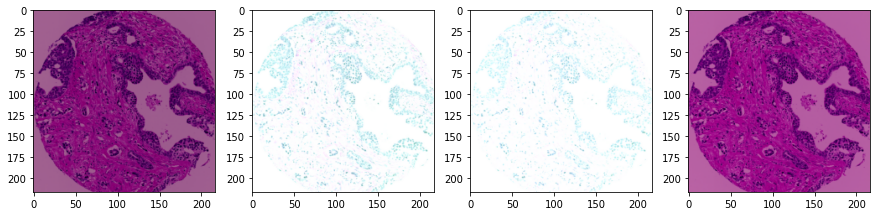

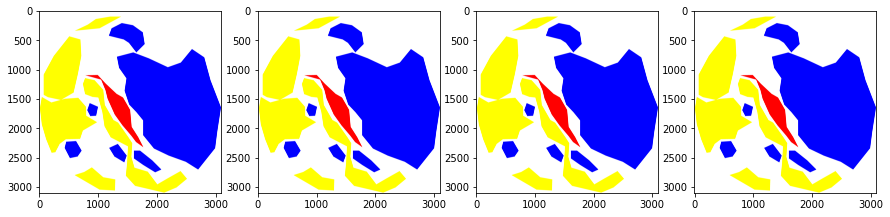

In [ ]:

(train_x, train_y), (valid_x, valid_y), (test_x, test_y)= load_data('./data')

fig = plt.figure(figsize=(15, 15))
a = fig.add_subplot(1, 4, 1)
imgplot = plt.imshow(read_and_rgb(train_x[0]))

a = fig.add_subplot(1, 4, 2)
imgplot = plt.imshow(read_and_rgb(train_x[1]))
imgplot.set_clim(0.0, 0.7)

a = fig.add_subplot(1, 4, 3)
imgplot = plt.imshow(read_and_rgb(train_x[2]))
imgplot.set_clim(0.0, 1.4)

a = fig.add_subplot(1, 4, 4)
imgplot = plt.imshow(read_and_rgb(train_x[3]))
imgplot.set_clim(0.0, 2.1)

fig = plt.figure(figsize=(15, 15))
a = fig.add_subplot(1, 4, 1)
imgplot = plt.imshow(read_and_rgb(train_y[0]))

a = fig.add_subplot(1, 4, 2)
imgplot = plt.imshow(read_and_rgb(train_y[1]))
imgplot.set_clim(0.0, 0.7)

a = fig.add_subplot(1, 4, 3)
imgplot = plt.imshow(read_and_rgb(train_y[2]))
imgplot.set_clim(0.0, 1.4)

a = fig.add_subplot(1, 4, 4)
imgplot = plt.imshow(read_and_rgb(train_y[3]))
imgplot.set_clim(0.0, 1.4)

In [ ]:
#UNet with pre-trained MobileNetV2

def model():
    inputs = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3), name="input_image")
    
    encoder = MobileNetV2(input_tensor=inputs, weights="imagenet", include_top=False, alpha=0.35)
    skip_connection_names = ["input_image", "block_1_expand_relu", "block_3_expand_relu", "block_6_expand_relu"]
    encoder_output = encoder.get_layer("block_13_expand_relu").output
    
    f = [16, 32, 48, 64]
    x = encoder_output
    for i in range(1, len(skip_connection_names)+1, 1):
        x_skip = encoder.get_layer(skip_connection_names[-i]).output
        x = UpSampling2D((2, 2))(x)
        x = Concatenate()([x, x_skip])
        
        x = Conv2D(f[-i], (3, 3), padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        
        x = Conv2D(f[-i], (3, 3), padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        
    x = Conv2D(1, (1, 1), padding="same")(x)
    x = Activation("sigmoid")(x)
    
    model = Model(inputs, x)
    return model

In [ ]:
# dice coefficient loss
smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

In [ ]:
#build input dataset

train_dataset = tf_dataset(train_x, train_y, batch=BATCH)
valid_dataset = tf_dataset(valid_x, valid_y, batch=BATCH)

In [ ]:
#compile model

model = model()
model.summary()



2023424/2019640 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 128, 128, 16) 432         input_image[0][0]                
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 128, 128, 16) 64          Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 128, 128, 16) 0           bn_Conv1[0][0]                   
_______________________________

In [ ]:
modelname= 'UnetAug_2'
folderpath      = '/content/gdrive/My Drive/iss/capstone/colab/'
filepath        = folderpath + modelname + ".hdf5"
checkpoint      = ModelCheckpoint(filepath, 
                                  monitor='val_dice_coef', 
                                  verbose=0, 
                                  save_best_only=True, 
                                  mode='max')

csv_logger      = CSVLogger(folderpath+modelname +'.csv')                       # Step 2
callbacks_list  = []                                       # Step 3

print("Path to model:", filepath)
print("Path to log:  ", folderpath+modelname+'.csv')

Path to model: /content/gdrive/My Drive/iss/capstone/colab/UnetAug_2.hdf5
Path to log:   /content/gdrive/My Drive/iss/capstone/colab/UnetAug_2.csv


In [ ]:
# Reduce learning rate or Stop training

callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=False),
    checkpoint,
    csv_logger
]

In [ ]:
#define the number of batches in an epoch

train_steps = len(train_x)//BATCH
valid_steps = len(valid_x)//BATCH

if len(train_x) % BATCH != 0:
    train_steps += 1
if len(valid_x) % BATCH != 0:
    valid_steps += 1

In [ ]:
opt = tf.keras.optimizers.Nadam(LR)
metrics = [dice_coef, Recall(), 'accuracy']
model.compile(loss=dice_loss, optimizer=opt, metrics=metrics)

AttributeError: ignored

In [ ]:
#train the model
model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=EPOCHS,
    steps_per_epoch=train_steps,
    validation_steps=valid_steps,
    callbacks=callbacks
)

Epoch 1/36
162/162 [==============================] - 868s 5s/step - loss: 0.3805 - dice_coef: 0.6195 - recall_1: 0.5635 - accuracy: 0.2995 - val_loss: 0.2795 - val_dice_coef: 0.7192 - val_recall_1: 0.7743 - val_accuracy: 0.4065
Epoch 2/36
162/162 [==============================] - 111s 685ms/step - loss: 0.2919 - dice_coef: 0.7081 - recall_1: 0.7123 - accuracy: 0.3743 - val_loss: 0.2295 - val_dice_coef: 0.7686 - val_recall_1: 0.9917 - val_accuracy: 0.4332
Epoch 3/36
162/162 [==============================] - 111s 686ms/step - loss: 0.2727 - dice_coef: 0.7273 - recall_1: 0.7755 - accuracy: 0.3877 - val_loss: 0.2149 - val_dice_coef: 0.7829 - val_recall_1: 0.9999 - val_accuracy: 0.4338
Epoch 4/36
162/162 [==============================] - 111s 686ms/step - loss: 0.2602 - dice_coef: 0.7398 - recall_1: 0.8115 - accuracy: 0.3943 - val_loss: 0.2114 - val_dice_coef: 0.7863 - val_recall_1: 1.0000 - val_accuracy: 0.4338
Epoch 5/36
162/162 [==============================] - 111s 684ms/step - los

In [ ]:
#evaluating the trained model on the test dataset
modelGo     = model()   # This is used for final testing
modelGo.load_weights(filepath)

opt = tf.keras.optimizers.Nadam(LR)
metrics = [dice_coef, Recall(), 'accuracy']
modelGo.compile(loss=dice_loss, optimizer=opt, metrics=metrics)




In [ ]:
test_dataset = tf_dataset(test_x, test_y, batch=BATCH)

test_steps = (len(test_x)//BATCH)
if len(test_x) % BATCH != 0:
    test_steps += 1

modelGo.evaluate(test_dataset, steps=test_steps)

31/31 [==============================] - 307s 9s/step - loss: 0.1602 - dice_coef: 0.8398 - recall_1: 0.9998 - accuracy: 0.4589


[0.15901751816272736,
 0.8411915898323059,
 0.9997906684875488,
 0.4589642584323883]

In [ ]:
def read_image(path):
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    #x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = x/255.0
    return x

def read_mask(path):
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = np.expand_dims(x, axis=-1)
    x = x/255.0
    return x

def mask_parse(mask):
    mask = np.squeeze(mask)
    mask = [mask, mask, mask]
    mask = np.transpose(mask, (1, 2, 0))
    return mask

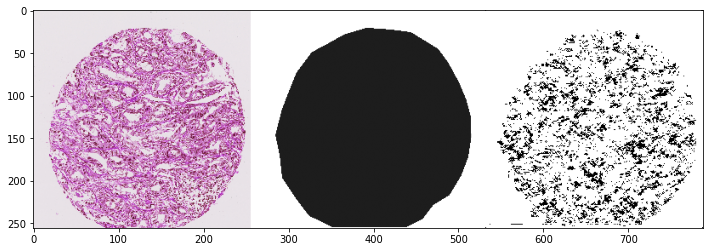

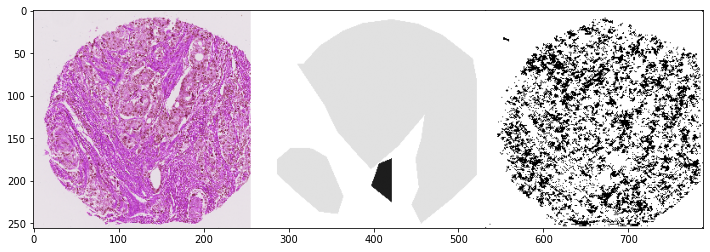

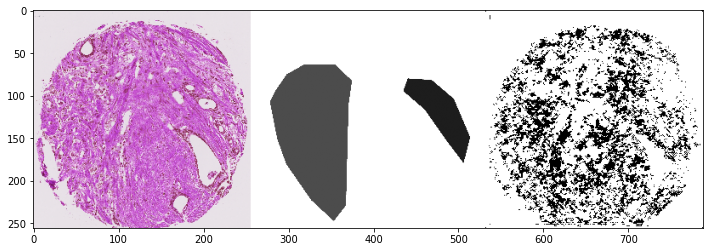

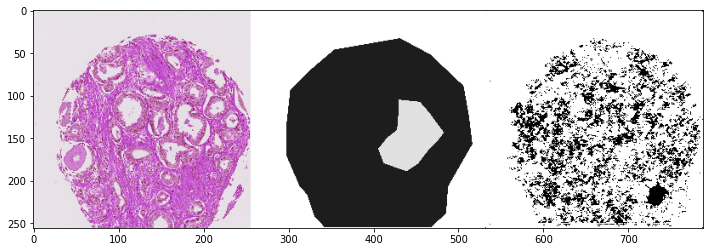

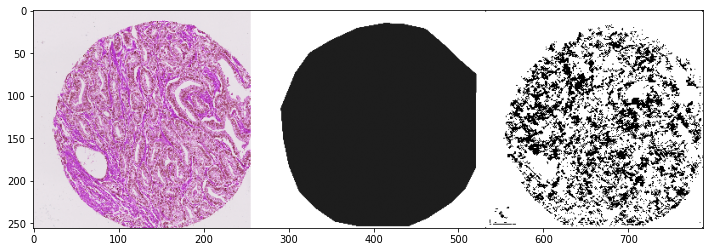

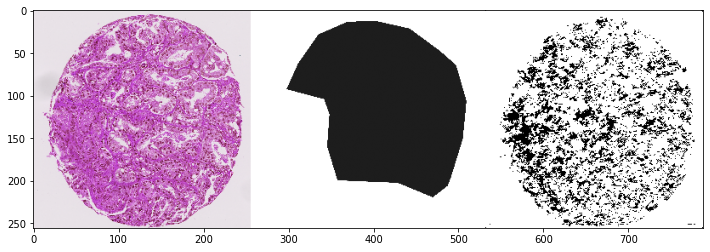

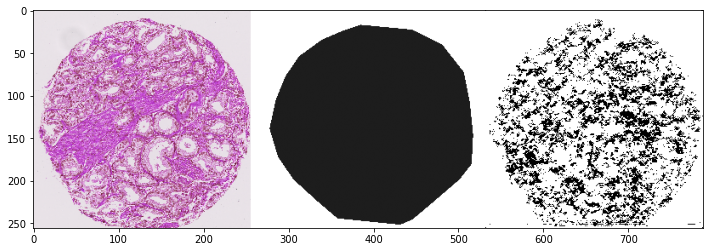

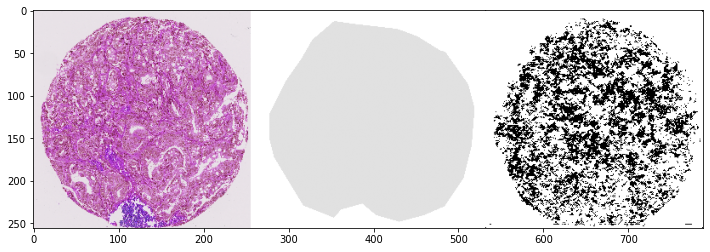

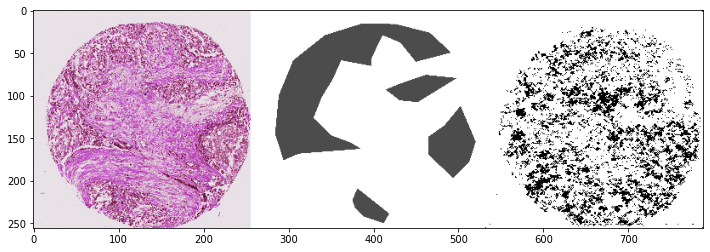

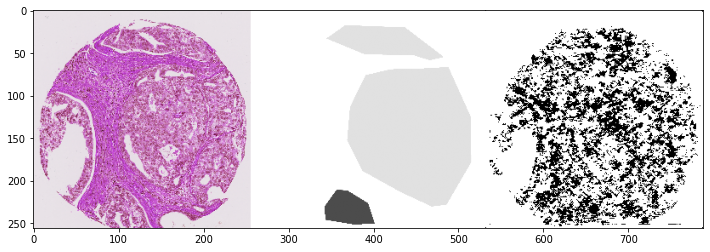

In [ ]:
#print result
from sklearn.preprocessing import normalize

for i, (x, y) in enumerate(zip(test_x[:10], test_y[:10])):
    x = read_image(x)
    y = read_mask(y)
    y_returned = modelGo.predict(np.expand_dims(x, axis=0))[0]
    #y_pred= np.round(normalize(y_returned[:,:, -1], norm='max', axis=0))
    #y_pred=np.expand_dims(y_pred, axis=-1)
    #print(y_pred*255)
    y_pred=np.where(y_returned <= 0.996, 0, 1)
    h, w, _ = x.shape
    white_line = np.ones((h, 10, 3))

    all_images = [
        x, white_line,
        mask_parse(y), white_line,
        mask_parse(y_pred)
    ]
    image = np.concatenate(all_images, axis=1)
    
    fig = plt.figure(figsize=(12, 12))
    a = fig.add_subplot(1, 1, 1)
    imgplot = plt.imshow(image)